In [1]:
"""

Variational Autoencoder with a STN and Modified Loss function and inverse STN and compare reconstruction loss
Removed the classification part 
Add the cost function of new VAE implementation of Tensorflow documentation
This is a MNIST classifier 

Add a decoder to clip values after inverse STN 

Encoder(Localizaton network) -> CNN to predict affine transformation matrix
STN -> Apply affine transformation
Decoder -> CNN to classify transformed images from STN

"""


'\n\nVariational Autoencoder with a STN and Modified Loss function and inverse STN and compare reconstruction loss\nRemoved the classification part \nAdd the cost function of new VAE implementation of Tensorflow documentation\nThis is a MNIST classifier \n\nAdd a decoder to clip values after inverse STN \n\nEncoder(Localizaton network) -> CNN to predict affine transformation matrix\nSTN -> Apply affine transformation\nDecoder -> CNN to classify transformed images from STN\n\n'

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Activation, Reshape
from tensorflow.keras import Model
import numpy as np
from utils.data_manager import ClutteredMNIST
from utils.visualizer import plot_mnist_sample
from utils.visualizer import print_evaluation
from utils.visualizer import plot_mnist_grid
from components.STN import BilinearInterpolation

## Dataset creation

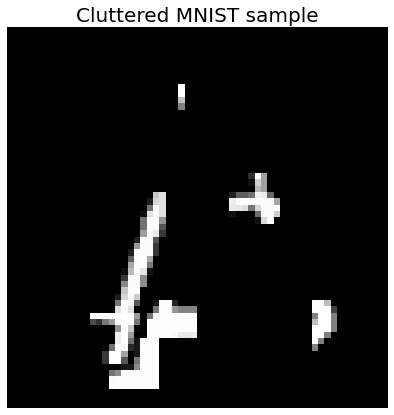

In [3]:
dataset_path = "./datasets/mnist_cluttered_60x60_6distortions.npz"
batch_size = 256
num_epochs = 30

data_manager = ClutteredMNIST(dataset_path)
train_data, val_data, test_data = data_manager.load()
x_train, y_train = train_data
plot_mnist_sample(x_train[7])

## Sampling layer

In [4]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder layer

In [5]:
class Encoder(layers.Layer):
  """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

  def __init__(self,
               latent_dim=3,
               intermediate_dim=64,
               name='encoder',
               **kwargs):
    super(Encoder, self).__init__(name=name, **kwargs)
    self.conv_1 = layers.Conv2D(20, (5, 5), padding='same', activation='relu')
    self.max_1 = layers.MaxPool2D(pool_size=(2, 2))
    self.conv_2 = layers.Conv2D(20, (5, 5), activation='relu')
    self.max_2 = layers.MaxPool2D(pool_size=(2, 2))
    
    self.flatten = layers.Flatten()
    
    self.dense_1 = layers.Dense(50, activation='relu')
    
    self.dense_mean = layers.Dense(3)
    self.dense_log_var = layers.Dense(3)
    
    self.sampling = Sampling()

  def call(self, inputs):
    x = self.conv_1(inputs)
    x = self.max_1(x)
    x = self.conv_2(x)
    x = self.max_2(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    z_mean = self.dense_mean(x)
    z_log_var = self.dense_log_var(x)
    z = self.sampling((z_mean, z_log_var))
    return z_mean, z_log_var, z


In [6]:
class DigitEncoder(layers.Layer):
  """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

  def __init__(self,
               name='digit_encoder',
               **kwargs):
    super(DigitEncoder, self).__init__(name=name, **kwargs)
    self.conv_1 = layers.Conv2D(20, (3, 3), padding='same', activation='relu')
    self.max_1 = layers.MaxPool2D(pool_size=(2, 2))
    self.conv_2 = layers.Conv2D(20, (3, 3), activation='relu')
    self.max_2 = layers.MaxPool2D(pool_size=(2, 2))
    
    self.flatten = layers.Flatten()
    
    self.dense_1 = layers.Dense(200, activation='relu')
    
    self.dense_mean = layers.Dense(50)
    self.dense_log_var = layers.Dense(50)
    
    self.sampling = Sampling()

  def call(self, inputs):
    x = self.conv_1(inputs)
    x = self.max_1(x)
    x = self.conv_2(x)
    x = self.max_2(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    z_mean = self.dense_mean(x)
    z_log_var = self.dense_log_var(x)
    z = self.sampling((z_mean, z_log_var))
    return z_mean, z_log_var, z


## Decoder layer

In [7]:
class Decoder(layers.Layer):
  """Converts z, the encoded digit vector, back into a readable digit."""

  def __init__(self,
               name='decoder',
               **kwargs):
    super(Decoder, self).__init__(name=name, **kwargs)
    self.flatten = layers.Flatten()
    self.dense_1 = layers.Dense(3600, activation='sigmoid')
    self.reshape = layers.Reshape((-1, 60, 60))

    
  def call(self, inputs):
    x = self.flatten(inputs)
    x = self.dense_1(x)
    x = self.reshape(x)
    return x


In [8]:
class DigitDecoder(layers.Layer):
  """Converts z, the encoded digit vector, back into a readable digit."""

  def __init__(self,
               name='decoder',
               **kwargs):
    super(DigitDecoder, self).__init__(name=name, **kwargs)
    self.dense_1 = layers.Dense(100, activation='relu')
    self.dense_2 = layers.Dense(3600, activation='relu')
    self.reshape = layers.Reshape((60, 60, 1))

    
  def call(self, inputs):
    x = self.dense_1(inputs)
    x = self.dense_2(x)
    x = self.reshape(x)
    return x


## Variational Auto Encoder

In [9]:
a = tf.ones((10,3))

In [10]:
b = tf.ones(a.shape)

In [11]:
class VariationalAutoEncoder(tf.keras.Model):
  """Combines the encoder and decoder into an end-to-end model for training."""

  def __init__(self,
               num_classes,
               intermediate_dim=64,
               latent_dim=3,
               name='autoencoder',
               **kwargs):
    super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
    self.num_classes = num_classes
    self.encoder = Encoder(latent_dim=latent_dim,
                           intermediate_dim=intermediate_dim)
    self.stn = BilinearInterpolation((30, 30), name='stn_layer')
    self.digit_encoder = DigitEncoder()
    self.digit_decoder = DigitDecoder()
    self.re_stn = BilinearInterpolation((60, 60), name='stn_layer')
#     self.decoder = Decoder()

  def call(self, inputs):
    z_mean, z_log_var, z_where = self.encoder(inputs)
    n = z_where.shape[0]
    z_where_indexes = tf.repeat([[0,0,1,0,0,2]], n, axis=0)
    z_where_selections = tf.repeat([[1.0, 0.0 , 1.0, 0.0, 1.0, 1.0]], n, axis=0)
    z_where_modified = tf.gather(z_where, z_where_indexes, batch_dims=1)
    z_where_modified = tf.math.multiply(z_where_modified, z_where_selections)
    
    inverse_z_where =  tf.map_fn(lambda x: x/x[0], z_where)
    inverse_z_where_compliments = tf.repeat([[1.0, -1.0 , -1.0]], n, axis=0)    
    inverse_z_where = tf.math.multiply(inverse_z_where, inverse_z_where_compliments)
    
    inverse_z_where_modified = tf.gather(inverse_z_where, z_where_indexes, batch_dims=1)
    inverse_z_where_modified = tf.math.multiply(inverse_z_where_modified, z_where_selections)
    
    
    transformed_image = self.stn([inputs, z_where_modified])
    
    z_what_mean, z_what_log_var, z_what = self.digit_encoder(transformed_image)
    reconstructed_crop = self.digit_decoder(z_what)
    
    reconstructed_image = self.re_stn([reconstructed_crop, inverse_z_where_modified])
    
    # Add KL divergence regularization loss.
    kl_loss_where = - 0.5 * tf.reduce_mean(
        z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
    self.add_loss(kl_loss_where)
    
    kl_loss_what = - 0.5 * tf.reduce_mean(
        z_what_log_var - tf.square(z_what_mean) - tf.exp(z_what_log_var) + 1)
    self.add_loss(kl_loss_what)
    
#     clipped_image = self.decoder(reconstructed_image)

    return transformed_image, [z_mean, z_log_var, z_where], [], reconstructed_image

In [12]:
num_classes = 10
vae = VariationalAutoEncoder(num_classes, 64, 6)

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
crossentropy_loss_fn = tf.keras.losses.CategoricalCrossentropy()


## Training

In [14]:
epochs = 100
batch_size = 128
iterations = x_train.shape[0] // batch_size
loss_metric = tf.keras.metrics.Mean()
mse_loss_fn = tf.keras.losses.MeanSquaredError()
mse_loss_log_fn = tf.keras.losses.MeanSquaredLogarithmicError()


In [15]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


In [16]:
for epoch in range(epochs):  
    print('Start of epoch %d' % (epoch,))
    inital_loss = 0
    # Iterate over the batches of the dataset.
    for batch_arg in range(iterations):
        
        with tf.GradientTape() as tape:
            arg_0 = batch_arg * batch_size
            arg_1 = (batch_arg + 1) * batch_size
            x_batch, y_batch = x_train[arg_0:arg_1], y_train[arg_0:arg_1]
            y_batch = y_batch.astype('float32')
            
            transformed_image, (z_mean, z_log_var, z_where), clipped_image ,reconstructed_image = vae(x_batch)
            
#             cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=classification, labels=y_batch)
#             logpx_z = -tf.reduce_sum(cross_ent, axis=[1])
#             logpz = log_normal_pdf(z_where, 0., 0.)
#             logqz_x = log_normal_pdf(z_where, z_mean, z_log_var)
#             loss =  -tf.reduce_mean(logpz - logqz_x)
            loss = mse_loss_log_fn(x_batch, reconstructed_image)
            print('***********')
            print(loss)
            loss += sum(vae.losses)
            
            inital_loss += sum(vae.losses)
            print(vae.losses)
            print(inital_loss)
            
#             loss = crossentropy_loss_fn(y_batch, classification)
#             loss += sum(vae.losses)
        
        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))
        
        loss_metric(loss)

        if batch_arg % 10 == 0:
          print('step %s: mean loss = %s' % (batch_arg, loss_metric.result()))
    print('Epoch loss:{}'.format(inital_loss))
        

Start of epoch 0
***********
tf.Tensor(0.02229908, shape=(), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.006838745>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0011596354>]
tf.Tensor(0.007998381, shape=(), dtype=float32)
Instructions for updating:
Use tf.identity instead.
step 0: mean loss = tf.Tensor(0.03029746, shape=(), dtype=float32)
***********
tf.Tensor(0.022177761, shape=(), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.009318442>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0006252598>]
tf.Tensor(0.017942082, shape=(), dtype=float32)
***********
tf.Tensor(0.022274068, shape=(), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.0021997334>, <tf.Tensor: shape=(), dtype=float32, numpy=0.00040841932>]
tf.Tensor(0.020550234, shape=(), dtype=float32)
***********
tf.Tensor(0.02166382, shape=(), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=0.00052554626>, <tf.Tensor: shape=(), dtype=float32, numpy=0.00022991747>]
tf.Tensor(0.0

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/chamathabeysinghe/Projects/monash/test/variational_auto_encoder/venv2/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-786edd1828ff>", line 32, in <module>
    grads = tape.gradient(loss, vae.trainable_weights)
  File "/Users/chamathabeysinghe/Projects/monash/test/variational_auto_encoder/venv2/lib/python3.7/site-packages/tensorflow/python/eager/backprop.py", line 1048, in gradient
    unconnected_gradients=unconnected_gradients)
  File "/Users/chamathabeysinghe/Projects/monash/test/variational_auto_encoder/venv2/lib/python3.7/site-packages/tensorflow/python/eager/imperative_grad.py", line 77, in imperative_grad
    compat.as_str(unconnected_gradients.value))
  File "/Users/chamathabeysinghe/Projects/monash/test/variational_auto_encoder/venv2/lib/python3.7/site-packages/tensorflow/python/eager/backprop.py", line 126, in _

KeyboardInterrupt: 

In [ ]:
vae.summary()

In [ ]:
visualize = x_train[30:40]

In [ ]:
transformed_image, [z_mean, z_log_var, z_where], clipped_image, reconstructed_image = vae(visualize)
# transformed_image, [z_mean, z_log_var, z_where], clipped_image, reconstructed_image

In [ ]:
z_mean

In [ ]:
plot_mnist_sample(transformed_image[0])

In [ ]:
plot_mnist_sample(visualize[0])

In [ ]:
index = 0

In [ ]:
mse_loss_log_fn(visualize, reconstructed_image)

In [ ]:
mse_loss_log_fn(visualize, reconstructed_image)

In [ ]:
plot_mnist_grid(visualize)

In [ ]:
plot_mnist_grid(transformed_image)


In [ ]:
result[3].shape

In [ ]:
plot_mnist_grid(reconstructed_image)
